In [12]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.sknet import SkNet
from torchvision import transforms

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [3]:
artifact_path = Path("../../artifacts/sknet")
data_path = Path("../../data/animal10")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(dataset.classes)

In [9]:
dataset.classes

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

In [10]:
len(dataset)

26179

pecora


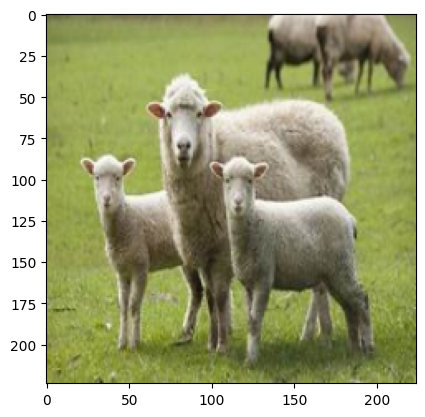

In [11]:
import random
demo_img, demo_label = dataset[random.randint(0, len(dataset))]
print(dataset.classes[demo_label])
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [13]:
model = SkNet(output_size=num_class, key=50).to(device)

In [14]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
SkNet                                                   --
├─Sequential: 1-1                                       --
│    └─ConvBnRelu: 2-1                                  --
│    │    └─Conv2d: 3-1                                 9,408
│    │    └─BatchNorm2d: 3-2                            128
│    │    └─ReLU: 3-3                                   --
│    └─MaxPool2d: 2-2                                   --
├─Sequential: 1-2                                       --
│    └─ResBlock: 2-3                                    --
│    │    └─BottleNeck: 3-4                             64,064
│    │    └─ConvBnRelu: 3-5                             16,896
│    └─ResBlock: 2-4                                    --
│    │    └─BottleNeck: 3-6                             88,640
│    │    └─Identity: 3-7                               --
│    └─ResBlock: 2-5                                    --
│    │    └─BottleNeck: 3-8        

# training

In [16]:
epochs = 10
acc_iters = 64 // BATCH_SIZE

In [ ]:
trainer = ClassificationTrainer(epochs, device, acc_iters)

In [15]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [17]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 1636/1636 [20:33<00:00,  1.33it/s]


epoch 1: 0.02894966494529805


100%|██████████| 1636/1636 [08:15<00:00,  3.30it/s]


epoch 2: 0.019835348371343046


100%|██████████| 1636/1636 [08:37<00:00,  3.16it/s]


epoch 3: 0.01580652578913267


100%|██████████| 1636/1636 [08:07<00:00,  3.36it/s]


epoch 4: 0.013247400774958118


100%|██████████| 1636/1636 [08:11<00:00,  3.33it/s]


epoch 5: 0.011613161132519994


100%|██████████| 1636/1636 [08:09<00:00,  3.34it/s]


epoch 6: 0.009999648026202474


100%|██████████| 1636/1636 [08:11<00:00,  3.33it/s]


epoch 7: 0.008403125701375327


100%|██████████| 1636/1636 [08:10<00:00,  3.33it/s]


epoch 8: 0.007300434492500263


100%|██████████| 1636/1636 [08:06<00:00,  3.36it/s]


epoch 9: 0.006529134702303293


100%|██████████| 1636/1636 [08:25<00:00,  3.24it/s]

epoch 10: 0.005845370598477051


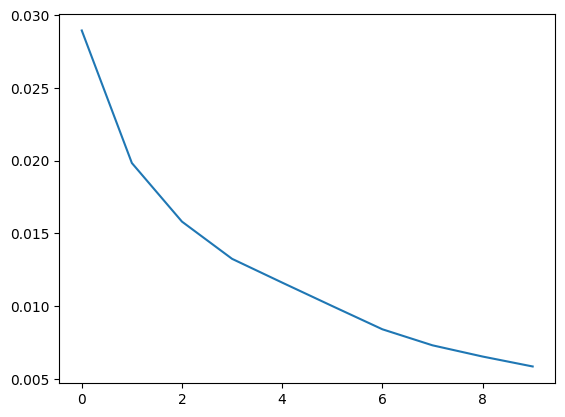

In [18]:
plt.plot(training_loss)

# inference

In [22]:
test_preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [23]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [24]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [25]:
evaluator = ClassificationEvaluator(num_class, device)

In [26]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 1637/1637 [03:35<00:00,  7.58it/s]


In [27]:
print(confusion_matrix)

[[4294   69   31    7  116  103   15   75  139   14]
 [  65 2408   13    8   23    4   25   33   32   12]
 [  23   27 1327    4   18    2    6   14   19    6]
 [   7    0    4 1768    7    3    0    4  315    4]
 [  16    6    5   25 2951    7    1   19   64    4]
 [  66    8    4    8   27 1485    3   16   40   11]
 [  47   77   22    9   29    5 1486  146   43    2]
 [  29   16   19    1   29    3   43 1637   37    6]
 [   6    1    1   19    6    1    0    3 4783    1]
 [  32    1    6   10   32   34    0   15  123 1609]]


In [28]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.88299403660292
cavallo   : 0.9180327868852459
elefante  : 0.9177040110650069
farfalla  : 0.8371212121212122
gallina   : 0.9525500322788896
gatto     : 0.8902877697841727
mucca     : 0.7963558413719185
pecora    : 0.8994505494505495
ragno     : 0.9921178178801079
scoiattolo: 0.864124597207304


In [29]:
per_class_acc.mean()

0.8950738654647328

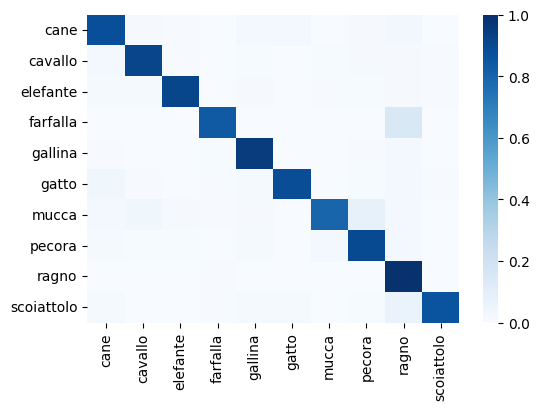

In [31]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [34]:
# image from internet
import requests
from io import BytesIO
from PIL import Image

# demo_url = "http://t2.gstatic.com/licensed-image?q=tbn:ANd9GcSFoiMCj_B7I2ML4tMYIbrcSgD9gBkp-G1JVfYz8R5xtL76jjcXyhY92BwcFNKCSxCU1NwmZ5XfIAO1VCF7WCM" # cow
demo_url = "http://t0.gstatic.com/licensed-image?q=tbn:ANd9GcRgs4mxH44aRwV3qnlSmBlnP2u4pEDu8gatItCeqvXEb3yUol302ClE9ujMszbxXiyPZopDy-3i9EzcjjLNdTI" # horse
img = Image.open(BytesIO(requests.get(demo_url).content))
img = test_preprocess(img).unsqueeze(0).to(device)

In [35]:
model.eval()
with torch.no_grad():
    prediction = model(img).detach().cpu()
    print(dataset.classes[prediction.argmax()])
    # print(dataset.classes[sample[1]])

cavallo


In [19]:
model_path = artifact_path / 'sknet50.pth'

In [20]:
torch.save(model.state_dict(), model_path)

In [21]:
get_file_size(model_path)

'97.66MB'

In [18]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>